LOADING AND INSPECTING DATA
Initial dataset shape: (15509, 10)

Columns: ['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

Data types:
Name         object
Year         object
Duration     object
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

Missing values:
Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

DATA CLEANING
Years extracted. Missing Years: 528
Duration cleaned. Missing Duration: 8269
Votes cleaned. Missing Votes: 7590
Rating cleaned. Missing Rating: 7590
Genre: filled missing with 'Unknown'
Director: filled missing with 'Unknown'
Actor 1: filled missing with 'Unknown'
Actor 2: filled missing with 'Unknown'
Actor 3: filled missing with 'Unknown'

HANDLING MISSING VALUES
Dropped 7590 ro

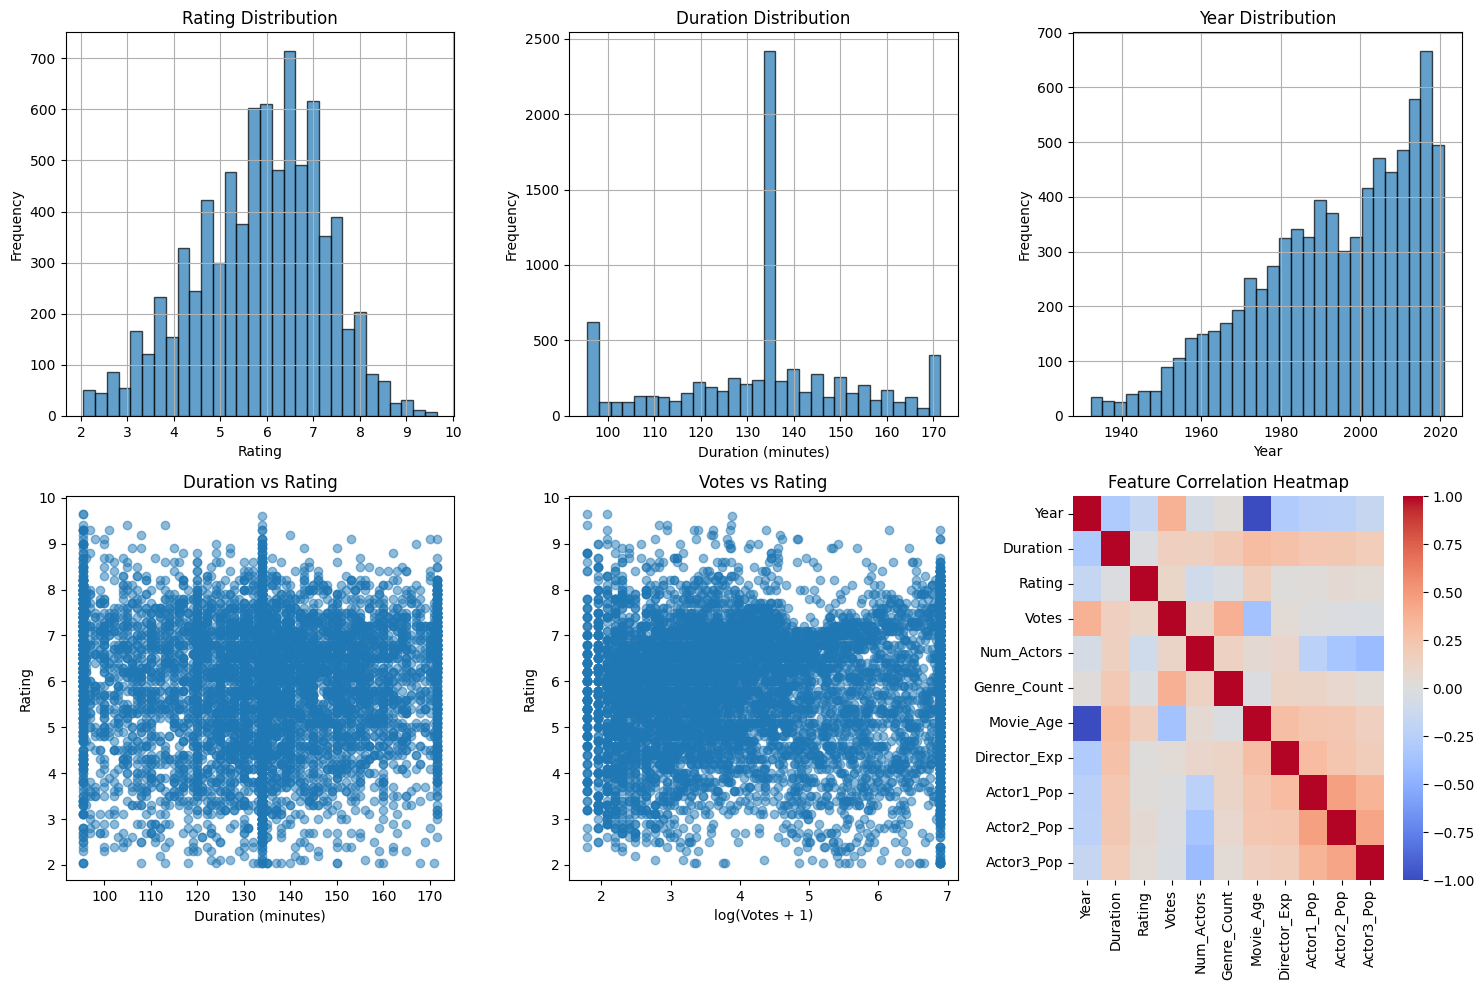


SPLITTING DATA
Training set: (6335, 15)
Test set: (1584, 15)
Features: ['Year', 'Duration', 'Genre', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Num_Actors', 'Genre_Count', 'Movie_Age', 'Director_Exp', 'Actor1_Pop', 'Actor2_Pop', 'Actor3_Pop']

HANDLING CATEGORICAL FEATURES
Categorical columns: ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
Encoding Genre...
Encoding Director...
Encoding Actor 1...
Encoding Actor 2...
Encoding Actor 3...

After encoding - Train shape: (6335, 15)
After encoding - Test shape: (1584, 15)

FINAL NAN CHECK AND IMPUTATION
Train NaN count: 0
Test NaN count: 0
Imputed any remaining NaN values with median

FEATURE SCALING
Training data scaled. Shape: (6335, 15)
Test data scaled. Shape: (1584, 15)

MODEL TRAINING

Training Linear Regression...
  Test R2: 0.220
  CV R2: 0.779 (±0.009)

Training Random Forest...
  Test R2: 0.125
  CV R2: 0.820 (±0.006)

Training Gradient Boosting...
  Test R2: 0.216
  CV R2: 0.811 (±0.011)

Training XGBoost...


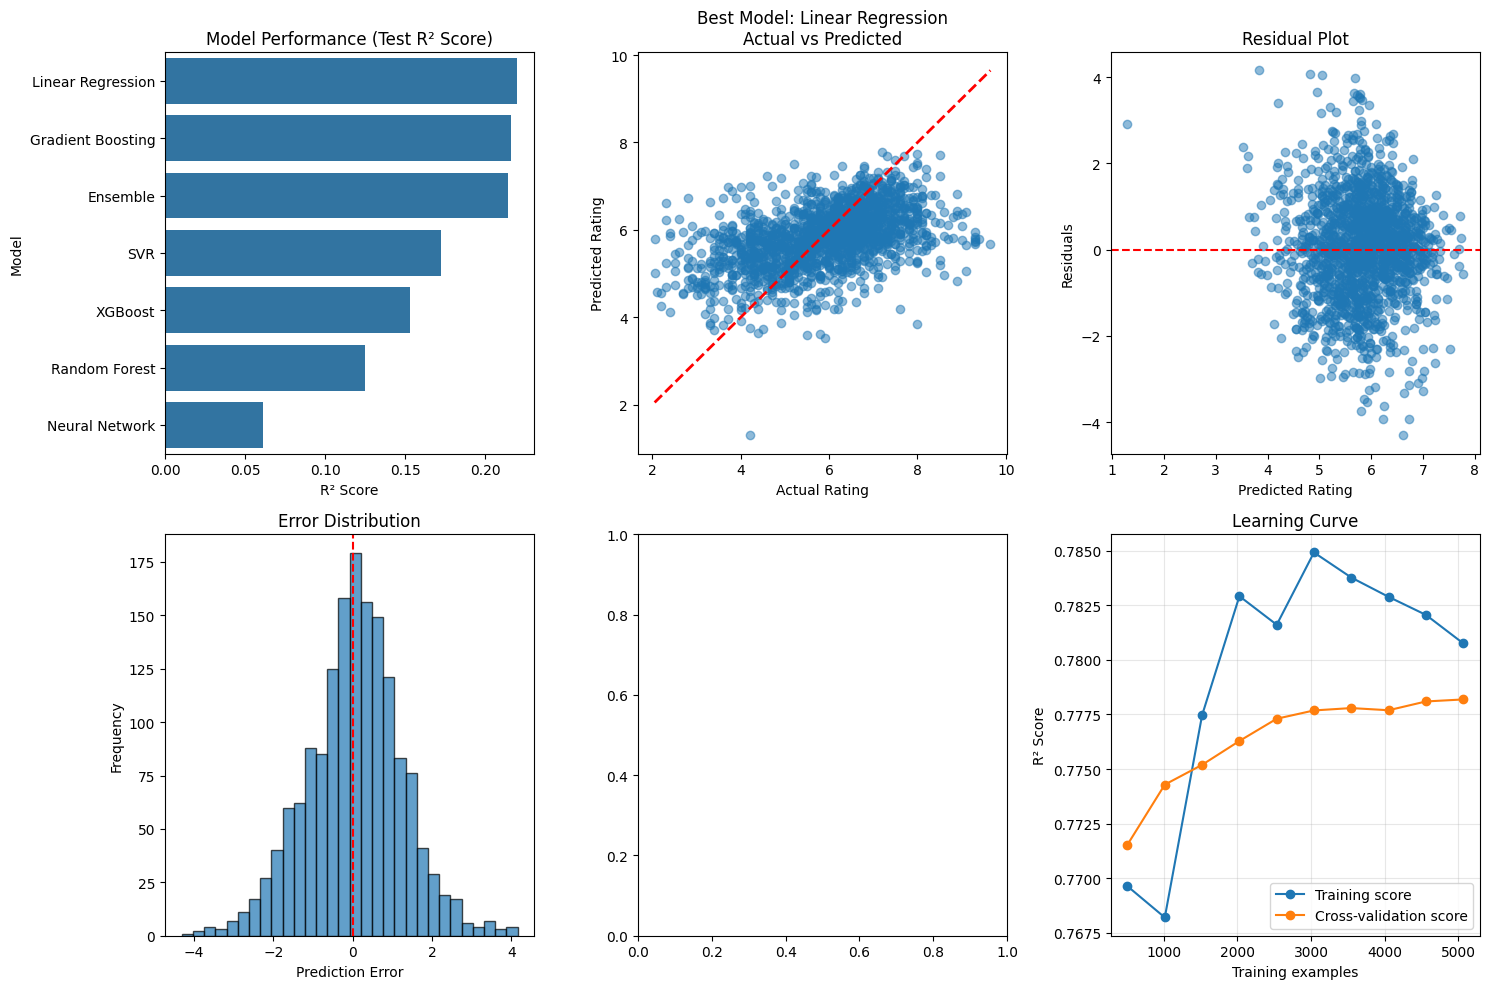


SAVING THE MODEL
Model saved as 'movie_rating_model.pkl'

EXAMPLE PREDICTION
Predicted rating for example movie: 84.0

Example movie features:
  Duration: 150
  Year: 2019
  Votes: 250000
  Genre: Action, Drama
  Director: Rajkumar Hirani
  Actor 1: Aamir Khan
  Actor 2: Kareena Kapoor
  Actor 3: Anil Kapoor
  Num_Actors: 3
  Genre_Count: 2
  Movie_Age: 5
  Director_Exp: 10
  Actor1_Pop: 50
  Actor2_Pop: 45
  Actor3_Pop: 40

FINAL SUMMARY
1. Best Model: Linear Regression
2. Best Test R²: 0.220
3. Test RMSE: 1.212
4. Test MAE: 0.935
5. Training samples: 6335
6. Test samples: 1584
7. Features used: 15
8. Categorical columns encoded: 5
9. Model saved to: 'movie_rating_model.pkl'
10. Prediction function ready: predict_movie_rating()

PROCESS COMPLETED SUCCESSFULLY!


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import joblib
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# ==================== 1. DATA LOADING & INITIAL INSPECTION ====================
print("="*60)
print("LOADING AND INSPECTING DATA")
print("="*60)

dataset = pd.read_csv("IMDb_Movies_India.csv", encoding="latin-1")
print(f"Initial dataset shape: {dataset.shape}")
print(f"\nColumns: {list(dataset.columns)}")
print(f"\nData types:\n{dataset.dtypes}")
print(f"\nMissing values:\n{dataset.isnull().sum()}")

# ==================== 2. DATA CLEANING ====================
print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

# Clean Year column
def safe_extract_year(year_str):
    if pd.isna(year_str):
        return np.nan
    try:
        matches = re.findall(r'\b\d{4}\b', str(year_str))
        if matches:
            year = int(matches[-1])
            return year if 1900 <= year <= datetime.now().year else np.nan
        return np.nan
    except:
        return np.nan

dataset['Year'] = dataset['Year'].apply(safe_extract_year)
print(f"Years extracted. Missing Years: {dataset['Year'].isna().sum()}")

# Clean Duration
def clean_duration(duration):
    if pd.isna(duration):
        return np.nan
    try:
        duration_str = str(duration).replace('min', '').strip()
        numbers = re.findall(r'\d+', duration_str)
        return float(numbers[0]) if numbers else np.nan
    except:
        return np.nan

dataset['Duration'] = dataset['Duration'].apply(clean_duration)
print(f"Duration cleaned. Missing Duration: {dataset['Duration'].isna().sum()}")

# Clean Votes
def clean_votes(votes):
    if pd.isna(votes):
        return np.nan
    try:
        votes_str = str(votes).replace(',', '').strip()
        return float(votes_str) if votes_str else np.nan
    except:
        return np.nan

dataset['Votes'] = dataset['Votes'].apply(clean_votes)
print(f"Votes cleaned. Missing Votes: {dataset['Votes'].isna().sum()}")

# Clean Rating
dataset['Rating'] = pd.to_numeric(dataset['Rating'], errors='coerce')
print(f"Rating cleaned. Missing Rating: {dataset['Rating'].isna().sum()}")

# Clean text columns
text_columns = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
for col in text_columns:
    dataset[col] = dataset[col].fillna('Unknown').astype(str)
    print(f"{col}: filled missing with 'Unknown'")

# ==================== 3. HANDLE MISSING VALUES ====================
print("\n" + "="*60)
print("HANDLING MISSING VALUES")
print("="*60)

# First, handle Rating (target variable)
initial_rows = len(dataset)
dataset = dataset.dropna(subset=['Rating'])
print(f"Dropped {initial_rows - len(dataset)} rows with missing Rating")

# Impute other missing values with median
imputation_values = {
    'Duration': dataset['Duration'].median(),
    'Year': dataset['Year'].median(),
    'Votes': dataset['Votes'].median()
}

for col, value in imputation_values.items():
    missing_before = dataset[col].isna().sum()
    dataset[col] = dataset[col].fillna(value)
    print(f"Imputed {missing_before} missing values in {col} with {value}")

print(f"\nRemaining missing values: {dataset.isnull().sum().sum()}")

# ==================== 4. FEATURE ENGINEERING ====================
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Basic features
dataset['Num_Actors'] = dataset[['Actor 1', 'Actor 2', 'Actor 3']].apply(
    lambda x: sum(1 for val in x if val != 'Unknown'), axis=1
)
print(f"Created Num_Actors feature")

dataset['Genre_Count'] = dataset['Genre'].apply(
    lambda x: len(str(x).split(',')) if x != 'Unknown' else 1
)
print(f"Created Genre_Count feature")

# Time-based features
current_year = datetime.now().year
dataset['Movie_Age'] = current_year - dataset['Year']
print(f"Created Movie_Age feature")

# Director experience (count of movies)
director_counts = dataset['Director'].value_counts()
dataset['Director_Exp'] = dataset['Director'].map(director_counts)
print(f"Created Director_Exp feature")

# Actor popularity
all_actors = pd.concat([dataset['Actor 1'], dataset['Actor 2'], dataset['Actor 3']])
actor_counts = all_actors.value_counts()
dataset['Actor1_Pop'] = dataset['Actor 1'].map(actor_counts)
dataset['Actor2_Pop'] = dataset['Actor 2'].map(actor_counts)
dataset['Actor3_Pop'] = dataset['Actor 3'].map(actor_counts)
print(f"Created Actor popularity features")

# ==================== 5. OUTLIER HANDLING ====================
print("\n" + "="*60)
print("OUTLIER HANDLING")
print("="*60)

def cap_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower_bound, upper_bound)

numerical_cols = ['Rating', 'Duration', 'Votes', 'Year', 'Movie_Age', 
                  'Director_Exp', 'Actor1_Pop', 'Actor2_Pop', 'Actor3_Pop']
for col in numerical_cols:
    if col in dataset.columns:
        dataset[col] = cap_outliers_iqr(dataset[col])
        print(f"Capped outliers in {col}")

# ==================== 6. EXPLORATORY DATA ANALYSIS ====================
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

plt.figure(figsize=(15, 10))

# 1. Rating distribution
plt.subplot(2, 3, 1)
dataset['Rating'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# 2. Duration distribution
plt.subplot(2, 3, 2)
dataset['Duration'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')

# 3. Year distribution
plt.subplot(2, 3, 3)
dataset['Year'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Year Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')

# 4. Rating vs Duration
plt.subplot(2, 3, 4)
plt.scatter(dataset['Duration'], dataset['Rating'], alpha=0.5)
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.title('Duration vs Rating')

# 5. Rating vs Votes (log scale)
plt.subplot(2, 3, 5)
plt.scatter(np.log1p(dataset['Votes']), dataset['Rating'], alpha=0.5)
plt.xlabel('log(Votes + 1)')
plt.ylabel('Rating')
plt.title('Votes vs Rating')

# 6. Correlation heatmap
plt.subplot(2, 3, 6)
corr_matrix = dataset.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

# ==================== 7. SPLIT DATA ====================
print("\n" + "="*60)
print("SPLITTING DATA")
print("="*60)

# Drop Name column
if 'Name' in dataset.columns:
    dataset = dataset.drop('Name', axis=1)

X = dataset.drop('Rating', axis=1)
y = dataset['Rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, q=5, duplicates='drop')
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features: {list(X_train.columns)}")

# ==================== 8. HANDLE CATEGORICAL FEATURES ====================
print("\n" + "="*60)
print("HANDLING CATEGORICAL FEATURES")
print("="*60)

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

# Initialize encoded dataframes
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

encoding_maps = {}  # Store encoding maps for saving

if categorical_cols:
    for col in categorical_cols:
        print(f"Encoding {col}...")
        
        # Create a mapping from category to mean rating in training data
        temp_df = X_train[[col]].copy()
        temp_df['rating'] = y_train
        
        # Calculate mean rating per category
        encoding_map = temp_df.groupby(col)['rating'].mean().to_dict()
        encoding_maps[col] = encoding_map  # Store for saving
        global_mean = y_train.mean()
        
        # Apply encoding
        X_train_encoded[f'{col}_encoded'] = X_train[col].map(encoding_map)
        X_test_encoded[f'{col}_encoded'] = X_test[col].map(encoding_map)
        
        # Fill NaN (unseen categories) with global mean
        X_train_encoded[f'{col}_encoded'].fillna(global_mean, inplace=True)
        X_test_encoded[f'{col}_encoded'].fillna(global_mean, inplace=True)
        
        # Drop original column
        X_train_encoded.drop(col, axis=1, inplace=True)
        X_test_encoded.drop(col, axis=1, inplace=True)

print(f"\nAfter encoding - Train shape: {X_train_encoded.shape}")
print(f"After encoding - Test shape: {X_test_encoded.shape}")

# ==================== 9. FINAL NAN CHECK AND IMPUTATION ====================
print("\n" + "="*60)
print("FINAL NAN CHECK AND IMPUTATION")
print("="*60)

# Check for any remaining NaN values
train_nan_count = X_train_encoded.isna().sum().sum()
test_nan_count = X_test_encoded.isna().sum().sum()

print(f"Train NaN count: {train_nan_count}")
print(f"Test NaN count: {test_nan_count}")

# Create and fit imputer
imputer = SimpleImputer(strategy='median')
X_train_encoded = pd.DataFrame(
    imputer.fit_transform(X_train_encoded),
    columns=X_train_encoded.columns
)
X_test_encoded = pd.DataFrame(
    imputer.transform(X_test_encoded),
    columns=X_test_encoded.columns
)
print("Imputed any remaining NaN values with median")

# ==================== 10. FEATURE SCALING ====================
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print(f"Training data scaled. Shape: {X_train_scaled.shape}")
print(f"Test data scaled. Shape: {X_test_scaled.shape}")

# ==================== 11. MODEL TRAINING ====================
print("\n" + "="*60)
print("MODEL TRAINING")
print("="*60)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0, n_jobs=-1),
    'SVR': SVR(),
    'Neural Network': MLPRegressor(random_state=42, max_iter=500, hidden_layer_sizes=(100, 50))
}

# Train and evaluate models
results = []
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Cross-validation
        cv_scores = cross_val_score(
            model, X_train_scaled, y_train, 
            cv=KFold(n_splits=5, shuffle=True, random_state=42),
            scoring='r2',
            n_jobs=-1
        )
        
        # Train on full training set
        model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        predictions[name] = y_pred_test
        
        # Calculate metrics
        results.append({
            'Model': name,
            'Train R2': r2_score(y_train, y_pred_train),
            'Test R2': r2_score(y_test, y_pred_test),
            'CV R2 Mean': cv_scores.mean(),
            'CV R2 Std': cv_scores.std(),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'Test MAE': mean_absolute_error(y_test, y_pred_test)
        })
        
        print(f"  Test R2: {results[-1]['Test R2']:.3f}")
        print(f"  CV R2: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
        
    except Exception as e:
        print(f"  Error with {name}: {str(e)}")
        results.append({
            'Model': name,
            'Train R2': np.nan,
            'Test R2': np.nan,
            'CV R2 Mean': np.nan,
            'CV R2 Std': np.nan,
            'Test RMSE': np.nan,
            'Test MAE': np.nan
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(results_df.sort_values('Test R2', ascending=False).to_string())

# ==================== 12. ENSEMBLE MODEL ====================
print("\n" + "="*60)
print("ENSEMBLE MODEL")
print("="*60)

# Create ensemble of top models
top_models = results_df.nlargest(3, 'Test R2')['Model'].tolist()
print(f"Creating ensemble with: {top_models}")

ensemble_models = []
for name in top_models:
    if name in models:
        ensemble_models.append((name, models[name]))

if len(ensemble_models) >= 2:
    ensemble = VotingRegressor(estimators=ensemble_models, n_jobs=-1)
    ensemble.fit(X_train_scaled, y_train)
    
    y_pred_ensemble = ensemble.predict(X_test_scaled)
    
    ensemble_results = {
        'Model': 'Ensemble',
        'Train R2': r2_score(y_train, ensemble.predict(X_train_scaled)),
        'Test R2': r2_score(y_test, y_pred_ensemble),
        'CV R2 Mean': np.nan,
        'CV R2 Std': np.nan,
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ensemble)),
        'Test MAE': mean_absolute_error(y_test, y_pred_ensemble)
    }
    
    results_df = pd.concat([results_df, pd.DataFrame([ensemble_results])], ignore_index=True)
    print(f"Ensemble Test R2: {ensemble_results['Test R2']:.3f}")

# ==================== 13. VISUALIZE RESULTS ====================
print("\n" + "="*60)
print("VISUALIZING RESULTS")
print("="*60)

plt.figure(figsize=(15, 10))

# 1. Model comparison
plt.subplot(2, 3, 1)
results_sorted = results_df.sort_values('Test R2', ascending=False)
sns.barplot(x='Test R2', y='Model', data=results_sorted)
plt.title('Model Performance (Test R² Score)')
plt.xlabel('R² Score')

# 2. Actual vs Predicted for best model
best_model_name = results_sorted.iloc[0]['Model']
if best_model_name in predictions:
    plt.subplot(2, 3, 2)
    plt.scatter(y_test, predictions[best_model_name], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title(f'Best Model: {best_model_name}\nActual vs Predicted')

# 3. Residual plot
if best_model_name in predictions:
    plt.subplot(2, 3, 3)
    residuals = y_test - predictions[best_model_name]
    plt.scatter(predictions[best_model_name], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

# 4. Error distribution
if best_model_name in predictions:
    plt.subplot(2, 3, 4)
    errors = y_test - predictions[best_model_name]
    plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')

# 5. Feature importance (for tree-based models)
plt.subplot(2, 3, 5)
if best_model_name == 'Random Forest' and 'Random Forest' in models:
    importances = models['Random Forest'].feature_importances_
    feature_names = X_train_encoded.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)
    
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Top 10 Feature Importances (Random Forest)')
    plt.tight_layout()

# 6. Learning curve for best model
plt.subplot(2, 3, 6)
if best_model_name in models:
    train_sizes, train_scores, test_scores = learning_curve(
        models[best_model_name], X_train_scaled, y_train,
        cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('R² Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 14. DETERMINE BEST MODEL ====================
best_model = None
if best_model_name == 'Ensemble' and 'ensemble' in locals():
    best_model = ensemble
elif best_model_name in models:
    best_model = models[best_model_name]
else:
    # Fallback to the first model
    best_model = list(models.values())[0]
    best_model_name = list(models.keys())[0]

# ==================== 15. SAVE THE MODEL ====================
print("\n" + "="*60)
print("SAVING THE MODEL")
print("="*60)

# Prepare model assets for saving
model_assets = {
    'model': best_model,
    'scaler': scaler,
    'imputer': imputer,
    'feature_names': X_train_encoded.columns.tolist(),
    'categorical_cols': categorical_cols,
    'encoding_maps': encoding_maps if categorical_cols else {},
    'global_mean': y_train.mean(),
    'results': results_df,
    'best_model_name': best_model_name
}

joblib.dump(model_assets, 'movie_rating_model.pkl')
print("Model saved as 'movie_rating_model.pkl'")

# ==================== 16. PREDICTION FUNCTION ====================
def predict_movie_rating(movie_features, model_path='movie_rating_model.pkl'):
    """Predict rating for a new movie"""
    try:
        # Load model assets
        assets = joblib.load(model_path)
        model = assets['model']
        scaler = assets['scaler']
        imputer = assets['imputer']
        feature_names = assets['feature_names']
        encoding_maps = assets.get('encoding_maps', {})
        global_mean = assets.get('global_mean', 6.0)
        
        # Create DataFrame with correct columns
        movie_df = pd.DataFrame([movie_features])
        
        # Apply encoding if we have categorical data
        if encoding_maps:
            for col, encoding_map in encoding_maps.items():
                encoded_col = f'{col}_encoded'
                if col in movie_df.columns:
                    movie_df[encoded_col] = movie_df[col].map(encoding_map)
                    movie_df[encoded_col].fillna(global_mean, inplace=True)
                    movie_df.drop(col, axis=1, inplace=True)
        
        # Ensure all required columns are present
        missing_cols = set(feature_names) - set(movie_df.columns)
        for col in missing_cols:
            movie_df[col] = np.nan
        
        # Reorder columns
        movie_df = movie_df[feature_names]
        
        # Handle NaN values
        movie_df = pd.DataFrame(imputer.transform(movie_df), columns=feature_names)
        
        # Scale features
        movie_scaled = scaler.transform(movie_df)
        
        # Make prediction
        prediction = model.predict(movie_scaled)[0]
        
        return round(prediction, 2)
    
    except Exception as e:
        print(f"Prediction error: {e}")
        return None

# ==================== 17. EXAMPLE PREDICTION ====================
print("\n" + "="*60)
print("EXAMPLE PREDICTION")
print("="*60)

# Create example movie
example_movie = {
    'Duration': 150,
    'Year': 2019,
    'Votes': 250000,
    'Genre': 'Action, Drama',
    'Director': 'Rajkumar Hirani',
    'Actor 1': 'Aamir Khan',
    'Actor 2': 'Kareena Kapoor',
    'Actor 3': 'Anil Kapoor',
    'Num_Actors': 3,
    'Genre_Count': 2,
    'Movie_Age': 5,
    'Director_Exp': 10,
    'Actor1_Pop': 50,
    'Actor2_Pop': 45,
    'Actor3_Pop': 40
}

# Add any missing features with default values
for feature in X_train_encoded.columns:
    if feature not in example_movie and '_encoded' not in feature:
        if feature in ['Duration', 'Year', 'Votes', 'Num_Actors', 'Genre_Count', 
                      'Movie_Age', 'Director_Exp', 'Actor1_Pop', 'Actor2_Pop', 'Actor3_Pop']:
            example_movie[feature] = X_train[feature].median()

predicted_rating = predict_movie_rating(example_movie)
if predicted_rating is not None:
    print(f"Predicted rating for example movie: {predicted_rating}")
    print(f"\nExample movie features:")
    for key, value in example_movie.items():
        print(f"  {key}: {value}")
else:
    print("Could not make prediction. Check the input features.")

# ==================== 18. FINAL SUMMARY ====================
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"1. Best Model: {best_model_name}")
print(f"2. Best Test R²: {results_sorted.iloc[0]['Test R2']:.3f}")
print(f"3. Test RMSE: {results_sorted.iloc[0]['Test RMSE']:.3f}")
print(f"4. Test MAE: {results_sorted.iloc[0]['Test MAE']:.3f}")
print(f"5. Training samples: {len(X_train)}")
print(f"6. Test samples: {len(X_test)}")
print(f"7. Features used: {len(X_train_encoded.columns)}")
print(f"8. Categorical columns encoded: {len(categorical_cols)}")
print(f"9. Model saved to: 'movie_rating_model.pkl'")
print(f"10. Prediction function ready: predict_movie_rating()")

print("\n" + "="*60)
print("PROCESS COMPLETED SUCCESSFULLY!")
print("="*60)

# Display feature importance if available
if 'importance_df' in locals():
    print("\n" + "="*60)
    print("TOP 5 MOST IMPORTANT FEATURES")
    print("="*60)
    print(importance_df.head(5).to_string(index=False))